<a href="https://colab.research.google.com/github/chuang-ma-ku/optimal-classifier/blob/main/LPM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cvxpy as cp
import csv
from cvxpy import log_sum_exp, sum, Minimize, Problem
from scipy import spatial
import torch

def cross_entropy_loss(logits, label):
    return -logits[label] + log_sum_exp(logits)

def get_total_loss(X, c, t1, t2, R):
    logits = X[0, c:]
    label = 0
    total_loss = cross_entropy_loss(logits, label)
    for i in range(t1)[1:]:
        logits = X[i, c:]
        label = i
        total_loss += cross_entropy_loss(logits, label)
    if R != float('inf'):
        for j in range(t2):
            logits = X[t1 + j, c:]
            label = t1 + j
            total_loss += (cross_entropy_loss(logits, label) / R)
    return total_loss

def get_constraints(X, c, Af, Aw):
    constraints = []
    constraints += [sum([X[i, i] for i in range(c)]) <= c * Af]
    constraints += [sum([X[c + j, c + j] for j in range(c)]) <= c * Aw]
    constraints += [X >> 0]
    # X >= 0
    return constraints

def neural_collapse_optimization(class_num, big_class_num, ratio, feature_constant, weight_constant):
    c = class_num
    t1 = big_class_num
    t2 = c - t1
    R = ratio
    Af = feature_constant
    Aw = weight_constant
    global X
    X = cp.Variable((2 * c, 2 * c), symmetric=True)
    total_loss = get_total_loss(X, c, t1, t2, R)
    constraints = get_constraints(X, c, Af, Aw)
    obj = Minimize(total_loss)
    prob = Problem(obj, constraints)
    try:
        prob.solve()
    except Exception as e:
        print(e)

    X_round = []
    for i in range(len(X.value)):
        X_round.append([round(X.value[i][j], 3) for j in range(len(X.value[0]))])
    # print(X_round)
    with open('tmp_matrix.csv', 'w') as f:
        writer = csv.writer(f)
        for i in range(len(X_round)):
            writer.writerow(X_round[i])
    between_class_cos_small = []
    for i in range(2 * c)[c + t1: ]:
        for j in range(2 * c)[c + t1:]:
            if i != j:
                cos_value = X.value[i, j] / np.sqrt(X.value[i, i] * X.value[j, j])
                between_class_cos_small.append(cos_value)
    return np.mean(between_class_cos_small)

def run_optimization_experiments():
    class_num = 10
    big_class_num = 5
    feature_constant = 10
    weight_constant = 1
    #ratio_list = [np.power(10, i * 0.1) for i in range(41)]
    ratio_list = [10]
    cos_values = []

    for x in range(len(ratio_list)):
        ratio = ratio_list[x]
        cos_values.append(neural_collapse_optimization(class_num, big_class_num, ratio,feature_constant, weight_constant))

def generate_random_orthogonal_matrix(feat_in, num_classes):
    a = np.random.random(size=(feat_in, num_classes))
    P, _ = np.linalg.qr(a)
    P = torch.tensor(P).float()
    assert torch.allclose(torch.matmul(P.T, P), torch.eye(num_classes), atol=1e-07), torch.max(torch.abs(torch.matmul(P.T, P) - torch.eye(num_classes)))
    return P

run_optimization_experiments()

In [ ]:
X_tensor = torch.from_numpy(X.value).float()
eigvals, eigvecs = torch.linalg.eigh(X_tensor)
sqrt_eigvals = torch.sqrt(torch.abs(eigvals))
sqrt_matrix = eigvecs @ torch.diag(sqrt_eigvals) @ eigvecs.T

num_classes = 10
feat_in = 512

P = generate_random_orthogonal_matrix(feat_in, 2*num_classes)
I = torch.eye(num_classes)
one = torch.ones(num_classes, num_classes)
PM = torch.matmul(P, sqrt_matrix)

print(PM.shape)
print(type(PM))

torch.Size([512, 20])
<class 'torch.Tensor'>


In [ ]:
W_star = PM[:, num_classes:]
W_star = W_star.cuda()

print(W_star.shape)
print(type(W_star))
W_star

torch.Size([512, 10])
<class 'torch.Tensor'>


tensor([[-5.8895e-02,  3.4436e-02,  3.1884e-03,  ..., -2.0177e-02,
         -1.8748e-02,  4.8152e-02],
        [ 8.8851e-03, -5.5590e-02,  6.9516e-05,  ...,  1.5108e-02,
          3.3446e-02, -2.7632e-02],
        [-4.4624e-02,  3.7268e-02, -1.1849e-02,  ...,  1.2663e-03,
         -2.1864e-02, -2.3306e-02],
        ...,
        [-2.8598e-02, -2.7550e-02,  3.5846e-02,  ...,  5.3498e-02,
          8.0534e-03,  7.8552e-03],
        [-8.9168e-03, -7.5477e-03,  4.4944e-02,  ..., -8.8942e-03,
          2.0205e-02, -2.5662e-03],
        [ 5.2730e-03,  1.2931e-02,  1.0842e-02,  ..., -1.8887e-02,
          4.1700e-02,  5.2348e-02]], device='cuda:0')

In [ ]:
H_star = PM[:, :num_classes]
H_star = H_star.cuda()

print(H_star.shape)
print(type(H_star))
H_star

torch.Size([512, 10])
<class 'torch.Tensor'>


tensor([[-0.1850,  0.1101,  0.0124,  ..., -0.0616, -0.0573,  0.1547],
        [ 0.0197, -0.1839, -0.0083,  ...,  0.0383,  0.0970, -0.0969],
        [-0.1339,  0.1246, -0.0308,  ...,  0.0121, -0.0607, -0.0653],
        ...,
        [-0.0917, -0.0879,  0.1121,  ...,  0.1683,  0.0250,  0.0242],
        [-0.0269, -0.0219,  0.1442,  ..., -0.0255,  0.0664, -0.0053],
        [ 0.0120,  0.0357,  0.0294,  ..., -0.0651,  0.1272,  0.1603]],
       device='cuda:0')

Files already downloaded and verified


Train Epoch: 99 [53/54 (98%)]	Loss: 0.765912: 100%|██████████| 54/54 [00:04<00:00, 12.28it/s]


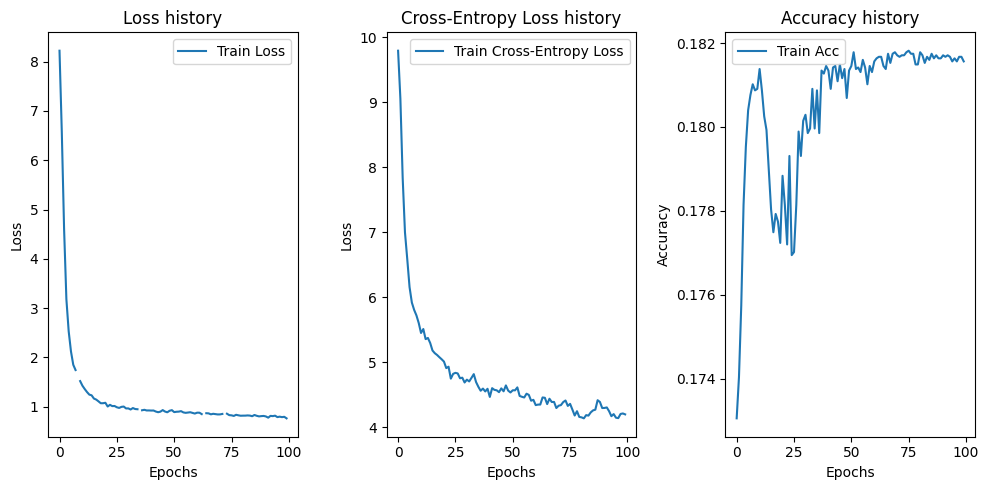

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                            download=True, transform=transform)

# Create an imbalanced dataset
class_counts = np.bincount(trainset.targets)
num_samples = class_counts.copy()
num_samples[5:] = num_samples[5:] // 10  # Reduce the number of samples for the last 5 classes

indices = []
for class_id, num_sample in enumerate(num_samples):
    class_indices = np.where(np.array(trainset.targets) == class_id)[0]
    indices.append(class_indices[:num_sample])

indices = np.concatenate(indices)
imbalanced_trainset = torch.utils.data.Subset(trainset, indices)

trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=512,
                                          shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                            download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=128,
#                                          shuffle=False, num_workers=2)


# Load the pre-trained ResNet18 model
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, 10)
resnet18.fc.bias.data.fill_(0)
resnet18 = resnet18.to(device)

# Define the feature extractor
feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])

# Set the last layer weights to W_star
with torch.no_grad():
    resnet18.fc.weight.copy_(W_star.T)
    resnet18.fc.bias.fill_(0.0)

# Define the optimizer
#optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(resnet18.parameters(), lr=0.00001)

# Define the loss function
mse_loss = nn.MSELoss()
#cross_entropy_loss = nn.CrossEntropyLoss()
cross_entropy = nn.CrossEntropyLoss()

# Lists for saving history
loss_history = []
acc_history = []
weighted_acc_history = []
cross_entropy_loss_history = []

# Compute the class weights
class_weights = num_samples / num_samples.sum()

# Training loop
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0.0
    total = 0.0
    weighted_correct = np.zeros(10)
    weighted_total = np.zeros(10)

    pbar = tqdm(enumerate(trainloader), total=len(trainloader))
    for i, data in pbar:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = feature_extractor(inputs)
        outputs = outputs.view(outputs.size(0), -1)

        # # Compute the mean feature for each class
        # H = []
        # for c in range(10):
        #     mask = (labels == c)
        #     H_c = torch.mean(outputs[mask], dim=0, keepdim=True)
        #     H.append(H_c)
        # H = torch.cat(H, dim=0)

        losses = []
        for c in range(10):
            mask = (labels == c)
            H_c = torch.mean(outputs[mask], dim=0, keepdim=True)
            h_star = H_star[:, c].unsqueeze(1)
            loss_c = mse_loss(H_c, h_star)
            losses.append(loss_c)

        loss = sum(losses)

        # loss = mse_loss(H, H_star.T)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(resnet18(inputs).data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_description(
            f"Train Epoch: {epoch} [{i}/{len(trainloader)} ({100.0 * i / len(trainloader):.0f}%)]\tLoss: {running_loss/(i+1):.6f}")

            # Update the weighted correct and total counts
        for c in range(10):
            mask = (labels == c)
            weighted_correct[c] += (predicted[mask] == labels[mask]).sum().item()
            weighted_total[c] += mask.sum().item()

    loss_history.append(running_loss/len(trainloader))
    acc_history.append(correct / total)
    weighted_acc_history.append(np.sum(weighted_correct) / np.sum(weighted_total))

    cross_entropy_losses = []
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = resnet18(inputs)
        loss = cross_entropy(outputs, labels)
        cross_entropy_losses.append(loss.item())
    cross_entropy_loss_history.append(sum(cross_entropy_losses) / len(cross_entropy_losses))


import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(loss_history, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(cross_entropy_loss_history, label='Train Cross-Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cross-Entropy Loss history')
plt.legend()

# Plotting the training accuracy
plt.subplot(1, 3, 3)
plt.plot(acc_history, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.legend()

# # Plotting the training accuracy
# plt.subplot(1, 4, 4)
# plt.plot(weighted_acc_history, label='Train Acc')
# plt.xlabel('Epochs')
# plt.ylabel('Weighted Accuracy')
# plt.title('Weighted Accuracy history')
# plt.legend()

plt.tight_layout()
plt.show()

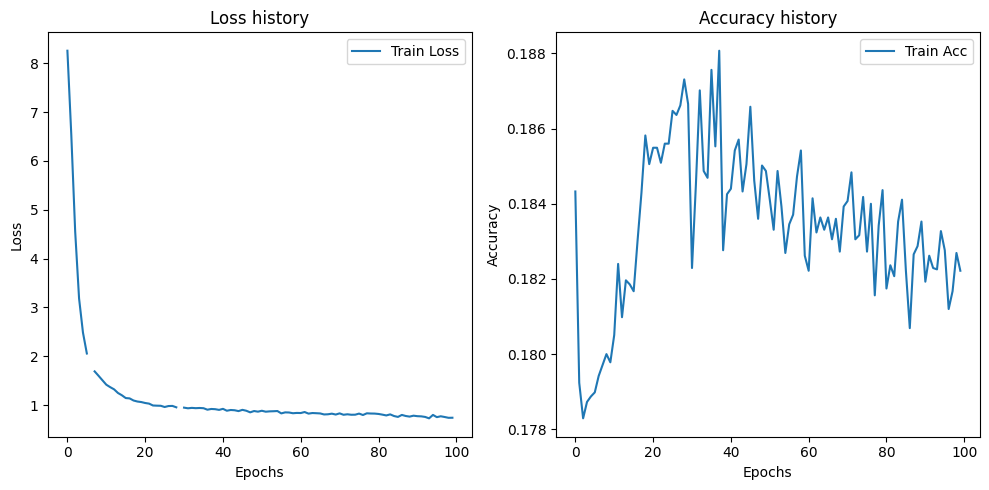

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend()

# Plotting the training accuracy
plt.subplot(1, 2, 2)
plt.plot(acc_history, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.legend()

plt.tight_layout()
plt.show()
